In [ ]:
import pandas as pd
import numpy as np

##Tasks

*   Device 1 : Panasonic Grid-EYE: standby power of around 2 mW and active power of around 50 mW.
*   Device 2 : Sentek pH-Probe: standby power of around 1 mW and active power of around 100 mW.
*   Device 3 : CHT3 capacitive humidity sensor from Sensirion: standby power of around 0.001 mW and active power of around 2 mW.





Panasonic Grid-EYE infrared array sensor, that has transition time of around 2 seconds from off to standby and less than 1ms from standby to active.


pH probes typically do not have the ability to be turned off or placed in standby mode, as they are continuously measuring the pH of a solution.
However, it's worth mentioning that, the Sentek pH-Probe sensor, which is a soil moisture and pH sensor, typically has a response time of around 1 second. Response time refers to the time it takes for the sensor to provide a measurement after being inserted into the soil.

In [ ]:
# Define the power usage for each device in each state

#in mW
power_usage = {
    "Device 1": {"off": 0, "idle": 2, "active": 50},
    "Device 2": {"off": 0, "idle": 1, "active": 100},
    "Device 3": {"off": 0, "idle": 0.001, "active": 2}
}

transition_times = {
"Device 1": {"off_to_idle": 2, "off_to_active": 2.01, "idle_to_active": 0.01, "active_to_idle": 0.01, "idle_to_off": 2, "active_to_off": 2.01},
"Device 2": {"off_to_idle": 0, "off_to_active": 0, "idle_to_active": 0, "active_to_idle": 0, "idle_to_off": 0, "active_to_off": 0},
"Device 3": {"off_to_idle": 0, "off_to_active": 0, "idle_to_active": 0, "active_to_idle": 0, "idle_to_off": 0, "active_to_off": 0}
}

transition_powers = {
"Device 1": {"off_to_idle": 2, "off_to_active": 2, "idle_to_active": 3, "active_to_idle": 4, "idle_to_off": 5, "active_to_off": 6},
"Device 2": {"off_to_idle": 3, "off_to_active": 2, "idle_to_active": 4, "active_to_idle": 5, "idle_to_off": 6, "active_to_off": 7},
"Device 3": {"off_to_idle": 4, "off_to_active": 2, "idle_to_active": 5, "active_to_idle": 6, "idle_to_off": 7, "active_to_off": 8}
}

# Define the current state for each device
current_state = {"Device 1": "off", "Device 2": "off", "Device 3": "off"}

# Define the tasks as a DataFrame
df_tasks = pd.DataFrame(data={
    "name": ["Task 1", "Task 2", "Task 3", "Task 4"],
    "Device 1": ["active", "idle", "off", "active"],
    "Device 2": ["active", "active", "idle", "active"],
    "Device 3": ["active", "idle", "idle", "off"],
    "deadline": [100, 50, 110, 70],
    "WCET": [40, 45, 30, 20],
    "Priority": [1, 2, 3, 4]
})

df_tasks['AET'] = .75*df_tasks['WCET']

current_time = 0
start_time = []
end_time = []

In [ ]:
# schedule df_tasks
schedule = []
while not df_tasks.empty:
    # update slack time for all df_tasks
    df_tasks['Slack Time'] = df_tasks['deadline'] - (current_time + df_tasks['WCET'])
    # sort df_tasks based on LST and priority
    df_tasks = df_tasks.sort_values(by=['Slack Time', 'Priority'], ascending=[True, False])
    # select next task
    next_task = df_tasks.iloc[0]
    schedule.append(next_task)
    start_time.append(current_time)
    # update current time
    current_time += next_task['AET']
    # remove task from list of df_tasks
    df_tasks = df_tasks.drop(next_task.name)
    end_time.append(current_time)

df_sch_tasks = pd.DataFrame(schedule, columns = ['name','deadline','WCET','Priority','AET','Slack Time','Device 1','Device 2','Device 3'])
df_sch_tasks['start_time'] = start_time
df_sch_tasks['end_time'] = end_time

##DPM

###with transition times

In [ ]:
# Continuously monitor the power usage of each device
while True:
    df_tasks["Slack Time"] = df_tasks["deadline"] - (current_time + df_tasks["WCET"])
    df_tasks = df_tasks.sort_values(by=['Slack Time', 'Priority'], ascending=[True, False])
    df_sch_tasks = df_tasks
    for _, task in df_tasks.iterrows():
        can_execute = True
        for device in ["Device 1", "Device 2", "Device 3"]:
            if task[f"{device}"] not in power_usage[device]:
                can_execute = False
                break
        if can_execute:
            device_active_energy = 0
            
            # Execute the task
            print(f"Executing {task['name']}...")
            transition = f"{current_state[device]}to{task[f'{device}']}"
            for device in ["Device 1", "Device 2", "Device 3"]:
                device_active_energy += power_usage[device][task[f"{device}"]]*task.AET
                
                #transition
                device_transition_energy = 0
                current_state_name = current_state[device]
                next_state_name = task[f"{device}"]
                if current_state_name != next_state_name:
                    transition_key = f"{current_state_name}_to_{next_state_name}"
                    transition_time = transition_times[device][transition_key]
                    transition_power = transition_powers[device][transition_key]
                    device_transition_energy = transition_time * transition_power
                    device_active_energy += device_transition_energy


                current_state[device] = task[f"{device}"]
                
            df_sch_tasks.loc[task.name,"device_active_energy"] = device_active_energy
            df_sch_tasks.loc[task.name,"device_transition_energy"] = device_transition_energy
            df_sch_tasks.loc[task.name,"total_energy"] = device_active_energy + device_transition_energy


            start_time.append(current_time)
            current_time += task['AET']
            end_time.append(current_time)

            df_tasks = df_tasks.drop(index=task.name)
            if df_tasks.empty:
                print("All Tasks Done!")
                break
        else:
            # Invalid state, do not execute task
            print(f"Skipping {task['name']}, invalid state.")

    if df_tasks.empty:
        break

df_sch_tasks['start_time'] = start_time
df_sch_tasks['end_time'] = end_time

Executing Task 2...
Executing Task 4...
Executing Task 1...
Executing Task 3...
All Tasks Done!


### ignoring transion times

In [ ]:
# Continuously monitor the power usage of each device
df_tasks = df_sch_tasks
while True:
    for _, task in df_tasks.iterrows():
        can_execute = True
        for device in ["Device 1", "Device 2", "Device 3"]:
            if task[f"{device}"] not in power_usage[device]:
                can_execute = False
                break
        if can_execute:
            device_active_power = 0
            device_active_energy = 0
            
            # Execute the task
            print(f"Executing {task['name']}...")
            for device in ["Device 1", "Device 2", "Device 3"]:
                device_active_power += power_usage[device][task[f"{device}"]]

                current_state[device] = task[f"{device}"]
            
            df_sch_tasks.loc[task.name,"device_active_power"] = device_active_power   

            df_tasks = df_tasks.drop(index=task.name)
            if df_tasks.empty:
                print("All Tasks Done!")
                break
        else:
            # Invalid state, do not execute task
            print(f"Skipping {task['name']}, invalid state.")

    if df_tasks.empty:
        break

df_sch_tasks = df_sch_tasks.reset_index()

Executing Task 2...
Executing Task 4...
Executing Task 1...
Executing Task 3...
All Tasks Done!


In [ ]:
display(df_sch_tasks)

,index,name,deadline,WCET,Priority,AET,Slack Time,Device 1,Device 2,Device 3,start_time,end_time,device_active_power
0,1,Task 2,50,45,2,33.75,5.00,idle,active,idle,0.00,33.75,102.001
1,3,Task 4,70,20,4,15.00,16.25,active,active,off,33.75,48.75,150.000
2,0,Task 1,100,40,1,30.00,11.25,active,active,active,48.75,78.75,152.000
3,2,Task 3,110,30,3,22.50,1.25,off,idle,idle,78.75,101.25,1.001


##DVS with external devices

In [ ]:
# approximate values for Intel Core i7-9700K 

P_dyn_1 = 125 # W dynamic power at max frequency
P_static = 75 # W static power (assumed to be constant)
P_cpu = P_dyn_1 + P_static # W CPU power

In [ ]:
df_task_dvs = df_sch_tasks[['name','deadline','WCET','AET','device_active_power']]

In [ ]:
df_task_dvs['i_mu'] = 1/(df_task_dvs['WCET'].sum()/df_task_dvs['deadline'].sum())

<ipython-input-8-78a14886b934>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_task_dvs['i_mu'] = 1/(df_task_dvs['WCET'].sum()/df_task_dvs['deadline'].sum())


[limitations of DVS](https://drive.google.com/file/d/1hFt7SAzWnj6O9yxfqawd2k4MYLP5e6O0/view?usp=share_link)

In [ ]:
#Formula
sf_eq = pow(((2*P_dyn_1)/(P_static+df_task_dvs['device_active_power'])),1/3)
sf_eq = np.clip(round(sf_eq,2), a_min = 1, a_max = 4) # refer above image
df_task_dvs['sf_eq'] = sf_eq

<ipython-input-9-42e32886fb5a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_task_dvs['sf_eq'] = sf_eq


In [ ]:
df_task_dvs['sf_act'] = df_task_dvs[['i_mu','sf_eq']].min(axis=1)

<ipython-input-10-63ab99bcff97>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_task_dvs['sf_act'] = df_task_dvs[['i_mu','sf_eq']].min(axis=1)


In [ ]:
df_task_dvs['P_cpu_DVS'] = pow(df_task_dvs['sf_act'],-3)*P_dyn_1+P_static+df_task_dvs['device_active_power']
df_task_dvs['AET_cpu_DVS'] = df_task_dvs['sf_act']*df_task_dvs['AET']
df_task_dvs['E_cpu_DVS'] = (pow(df_task_dvs['sf_act'],-2)*P_dyn_1+df_task_dvs['sf_act']*(P_static+df_task_dvs['device_active_power']))*df_task_dvs['AET']

<ipython-input-11-a2618ba4731a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_task_dvs['P_cpu_DVS'] = pow(df_task_dvs['sf_act'],-3)*P_dyn_1+P_static+df_task_dvs['device_active_power']
<ipython-input-11-a2618ba4731a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_task_dvs['AET_cpu_DVS'] = df_task_dvs['sf_act']*df_task_dvs['AET']
<ipython-input-11-a2618ba4731a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [ ]:
df_task_dvs = df_task_dvs.round(2)

In [ ]:
display(df_task_dvs)

,name,deadline,WCET,AET,device_active_power,i_mu,sf_eq,sf_act,P_cpu_DVS,AET_cpu_DVS,E_cpu_DVS
0,Task 2,50,45,33.75,102.0,2.44,1.12,1.12,265.97,37.80,10053.80
1,Task 4,70,20,15.00,150.0,2.44,1.04,1.04,336.12,15.60,5243.54
2,Task 1,100,40,30.00,152.0,2.44,1.03,1.03,341.39,30.90,10549.03
3,Task 3,110,30,22.50,1.0,2.44,1.49,1.49,113.79,33.52,3814.77


##No DVS or DPM

In [ ]:
max_device_power = 0
for device in ["Device 1", "Device 2", "Device 3"]:
    max_device_power += power_usage[device]['active']

In [ ]:
df_max = df_sch_tasks[['name','deadline','WCET','AET']]
df_max['max_freq'] = 1
df_max['max_cpu_power'] = P_dyn_1 + P_static
df_max['max_device_power'] = max_device_power
df_max['total_max_power'] = df_max['max_cpu_power'] + df_max['max_device_power']
df_max['E_max'] = (df_max['total_max_power'])*df_max['AET']

<ipython-input-15-f39adf3280e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_max['max_freq'] = 1
<ipython-input-15-f39adf3280e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_max['max_cpu_power'] = P_dyn_1 + P_static
<ipython-input-15-f39adf3280e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [ ]:
display(df_max)

,name,deadline,WCET,AET,max_freq,max_cpu_power,max_device_power,total_max_power,E_max
0,Task 2,50,45,33.75,1,200,152,352,11880.0
1,Task 4,70,20,15.00,1,200,152,352,5280.0
2,Task 1,100,40,30.00,1,200,152,352,10560.0
3,Task 3,110,30,22.50,1,200,152,352,7920.0


##plot

In [ ]:
df_plot = df_max[['name', 'WCET', 'AET','max_freq','E_max']]
df_plot['AET_dvs_dpm'] = df_task_dvs['AET_cpu_DVS']
df_plot['freq_dvs_dpm'] = 1/df_task_dvs['sf_act']
df_plot['E_dvs_dpm'] = df_task_dvs['E_cpu_DVS']


df_plot['max_freq_start_time'] = df_plot['AET'].cumsum()-df_plot['AET']
df_plot['dvs_dpm_start_time'] = df_plot['AET_dvs_dpm'].cumsum()-df_plot['AET_dvs_dpm']
df_plot = df_plot.round(2)

In [ ]:
display(df_plot)

,name,WCET,AET,max_freq,E_max,AET_dvs_dpm,freq_dvs_dpm,E_dvs_dpm,max_freq_start_time,dvs_dpm_start_time
0,Task 2,45,33.75,1,11880.0,37.80,0.89,10053.80,0.00,0.0
1,Task 4,20,15.00,1,5280.0,15.60,0.96,5243.54,33.75,37.8
2,Task 1,40,30.00,1,10560.0,30.90,0.97,10549.03,48.75,53.4
3,Task 3,30,22.50,1,7920.0,33.52,0.67,3814.77,78.75,84.3


In [ ]:
titles = df_plot['name']
xmax = df_plot['AET_dvs_dpm'].sum()+10

ax1x = df_plot['max_freq_start_time'].tolist()
ax1y = df_plot['max_freq'].tolist()
ax1w = df_plot['AET'].tolist()
ax1title = 'Task profile of non-DPM_DVS schedule (E=100%)'
ax1_color = [(r,r,r) for r in np.linspace(0, 1, len(ax1w))]

ax2x = df_plot['dvs_dpm_start_time'].tolist()
ax2y = df_plot['freq_dvs_dpm'].tolist()
ax2w = df_plot['AET_dvs_dpm'].tolist()
ax2title = 'Task profile of DVS_DPM schedule (E='+ str(round((df_plot['E_dvs_dpm'].sum()/df_plot['E_max'].sum()*100),2)) +'%)'
ax2_color = [(r,r,r) for r in np.linspace(0, 1, len(ax2w))]

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30, 17.5)
plt.rcParams['font.size'] = 25

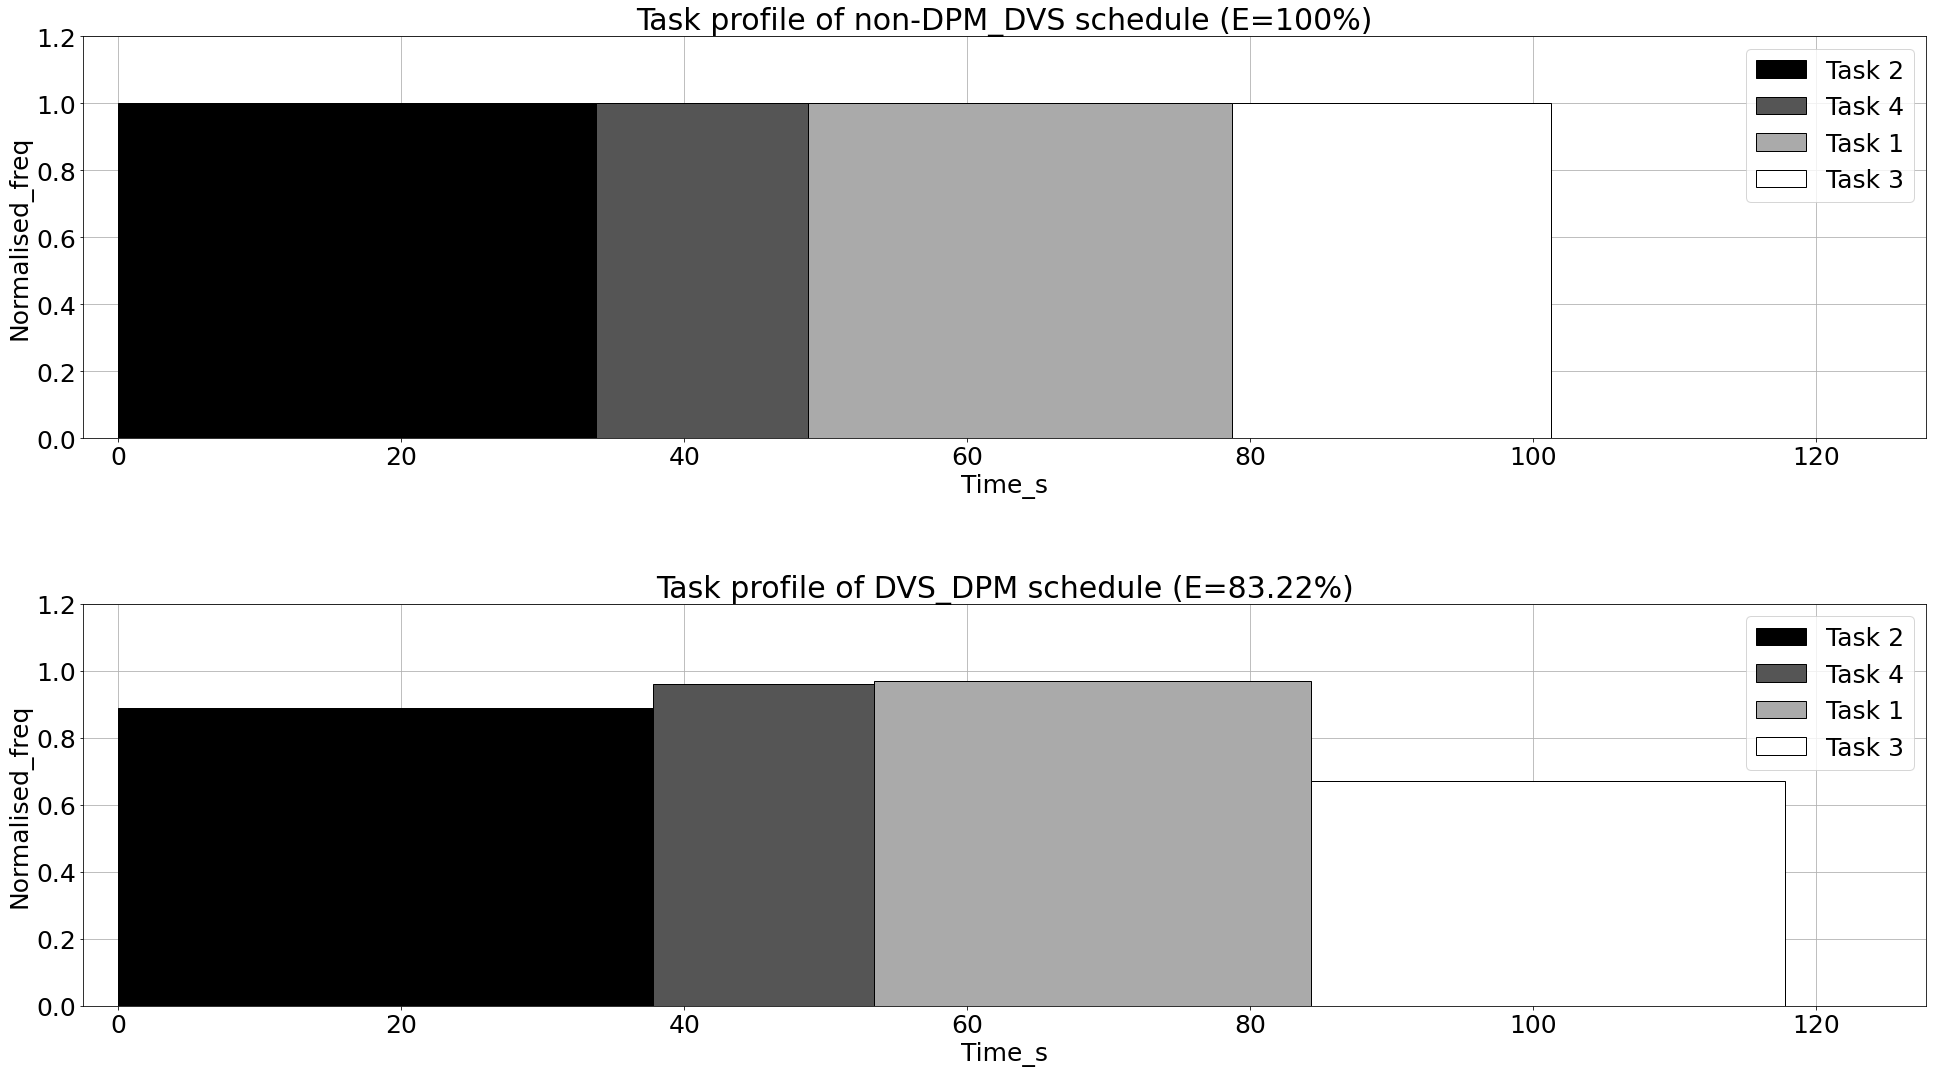

In [ ]:
fig, [ax1,ax2] = plt.subplots(2, 1)
fig.tight_layout(pad=5)
for i in range(len(ax1x)):
    ax1.bar(ax1x[i], ax1y[i], label=titles[i], align = 'edge', width = ax1w[i], color = ax1_color[i],edgecolor='k',zorder=3)
ax1.set(xlabel = 'Time_s', ylabel = 'Normalised_freq',xlim = (-2.5,xmax), ylim = (0,1.2), title = ax1title)
for i in range(len(ax1x)):
    ax2.bar(ax2x[i], ax2y[i], label=titles[i], align = 'edge', width = ax2w[i], color = ax2_color[i],edgecolor='k',zorder=3)
ax2.set(xlabel = 'Time_s', ylabel = 'Normalised_freq',xlim = (-2.5,xmax), ylim = (0,1.2), title = ax2title)
ax1.legend()
ax2.legend()
ax1.grid(zorder=0)
ax2.grid(zorder=0)

In [ ]:
df_plot_dev = df_sch_tasks[['Device 1','Device 2','Device 3']]
df_plot_dev = df_plot_dev.set_index(df_sch_tasks['name'])
df_plot_dev = df_plot_dev.replace(['active','idle','off'],[3,2,1])

In [ ]:
display(df_plot_dev)

,Device 1,Device 2,Device 3
name,,,
Task 2,2,3,2
Task 4,3,3,1
Task 1,3,3,3
Task 3,1,2,2


[Text(0, 0, ''), Text(0, 0, 'Off'), Text(0, 0, 'Idle'), Text(0, 0, 'Active')]

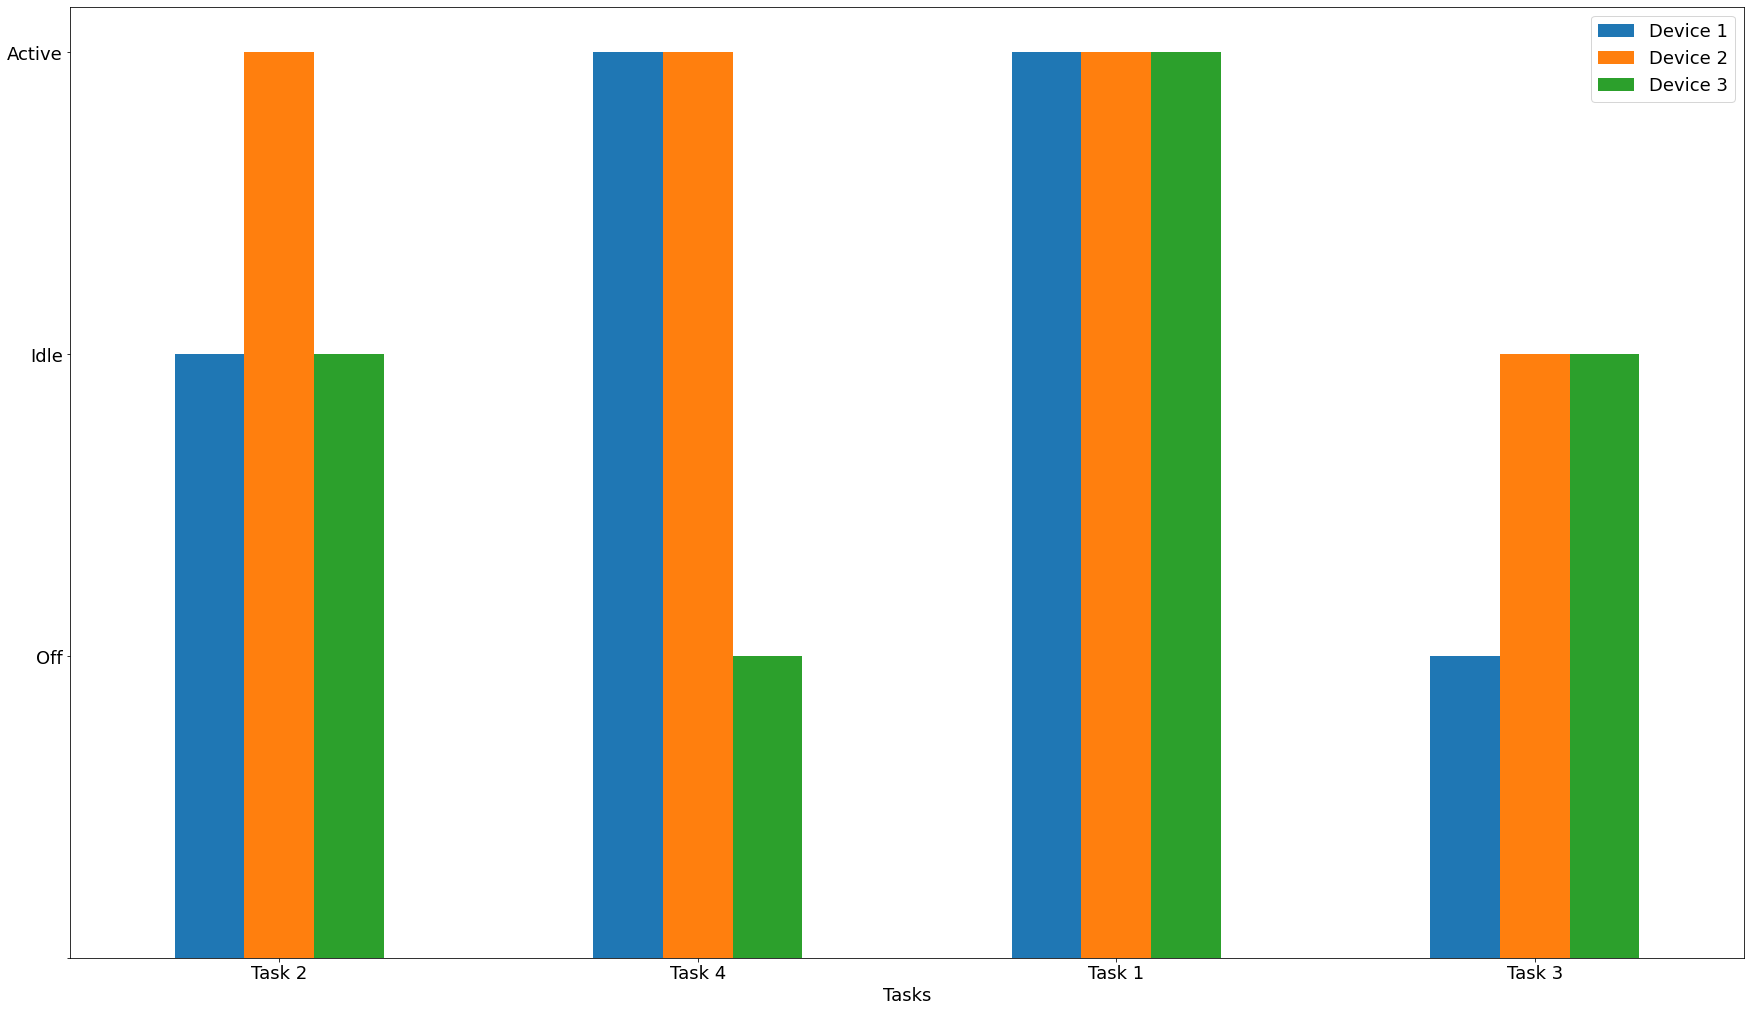

In [ ]:
plot = df_plot_dev.plot.bar(yticks=([0,1,2,3]),rot = 0)
plot.set_xlabel('Tasks')
plot.set_yticklabels(['','Off','Idle','Active'])